Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Epoch 1/50
Train Loss: 1.9987 | Acc: 0.5085
Val   Loss: 0.3183 | Acc: 0.8606
Model kaydedildi.

Epoch 2/50
Train Loss: 0.3375 | Acc: 0.8677
Val   Loss: 0.2114 | Acc: 0.8949
Model kaydedildi.

Epoch 3/50
Train Loss: 0.1897 | Acc: 0.9153
Val   Loss: 0.2477 | Acc: 0.8939
No improvement (1/5)

Epoch 4/50
Train Loss: 0.1149 | Acc: 0.9484
Val   Loss: 0.1875 | Acc: 0.9192
Model kaydedildi.

Epoch 5/50
Train Loss: 0.1105 | Acc: 0.9442
Val   Loss: 0.2233 | Acc: 0.9020
No improvement (1/5)

Epoch 6/50
Train Loss: 0.1065 | Acc: 0.9508
Val   Loss: 0.1806 | Acc: 0.9172
Model kaydedildi.

Epoch 7/50
Train Loss: 0.0795 | Acc: 0.9529
Val   Loss: 0.2357 | Acc: 0.9061
No improvement (1/5)

Epoch 8/50
Train Loss: 0.0892 | Acc: 0.9561
Val   Loss: 0.2587 | Acc: 0.8929
No improvement (2/5)

Epoch 9/50
Train Loss: 0.0851 | Acc: 0.9622
Val   Loss: 0.2101 | Acc: 0.9162
No improvemen

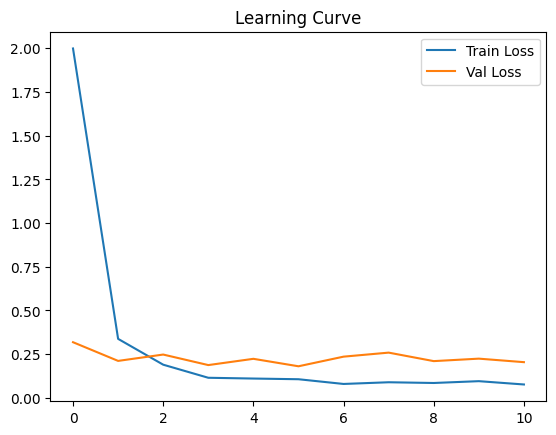

In [ ]:
# MultiZoo Transformer Tabanlı Görüntü Sınıflandırma Projesi (Google Colab)

# 1. Google Drive Bağlantısı
from google.colab import drive
drive.mount('/content/drive')

# 2. Zip dosyasını çıkarma
import zipfile
zip_path = "/content/drive/MyDrive/train.zip"
extract_path = "/content/multizoo_data"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# 3. Doğrulama verisini doğru ayırma (%80 - %20)
import os
import shutil
from sklearn.model_selection import train_test_split

base_dir = "/content/multizoo_data/train"
val_dir = "/content/val_data"

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir, exist_ok=True)

for cls in os.listdir(base_dir):
    cls_path = os.path.join(base_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    images = os.listdir(cls_path)
    if len(images) < 2:
        continue

    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)
    val_cls_path = os.path.join(val_dir, cls)
    os.makedirs(val_cls_path, exist_ok=True)

    for img in val_imgs:
        shutil.move(os.path.join(cls_path, img), os.path.join(val_cls_path, img))

# 4. Transformlar ve Dataset
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(base_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# 5. Swin Transformer Modeli ve Focal Loss
import timm
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)

model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=num_classes)

model.to(device)

# Focal Loss tanımı
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss
        return loss.mean()

criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# 6. Eğitim Döngüsü (Early Stopping ile)
import numpy as np
import time

num_epochs = 50
patience = 5
min_delta = 0.001
best_val_loss = np.inf
trigger_times = 0

train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)

    model.eval()
    val_running_loss = 0.0
    correct_val, total_val = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = val_running_loss / len(val_loader)
    val_acc = correct_val / total_val
    val_losses.append(val_loss)

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/content/drive/MyDrive/best_swin_model.pth")
        print("Model kaydedildi.")
        trigger_times = 0
    else:
        trigger_times += 1
        print(f"No improvement ({trigger_times}/{patience})")
        if trigger_times >= patience:
            print("Early stopping!")
            break

# 7. Öğrenme Eğrisi
import matplotlib.pyplot as plt
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Learning Curve")
plt.show()

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/best_swin_model.pth")
model.eval()

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

In [ ]:
from sklearn.metrics import classification_report

y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Detaylı rapor
print(classification_report(y_true, y_pred, target_names=val_dataset.classes))


                precision    recall  f1-score   support

      antelope       0.69      0.82      0.75        11
        badger       1.00      1.00      1.00        11
           bat       0.73      1.00      0.85        11
          bear       0.90      0.82      0.86        11
           bee       1.00      0.91      0.95        11
        beetle       1.00      0.91      0.95        11
         bison       1.00      0.55      0.71        11
          boar       1.00      0.91      0.95        11
     butterfly       1.00      0.82      0.90        11
           cat       0.92      1.00      0.96        11
   caterpillar       1.00      1.00      1.00        11
    chimpanzee       1.00      1.00      1.00        11
     cockroach       1.00      1.00      1.00        11
           cow       0.78      0.64      0.70        11
        coyote       1.00      0.82      0.90        11
          crab       1.00      1.00      1.00        11
          crow       1.00      0.73      0.84  

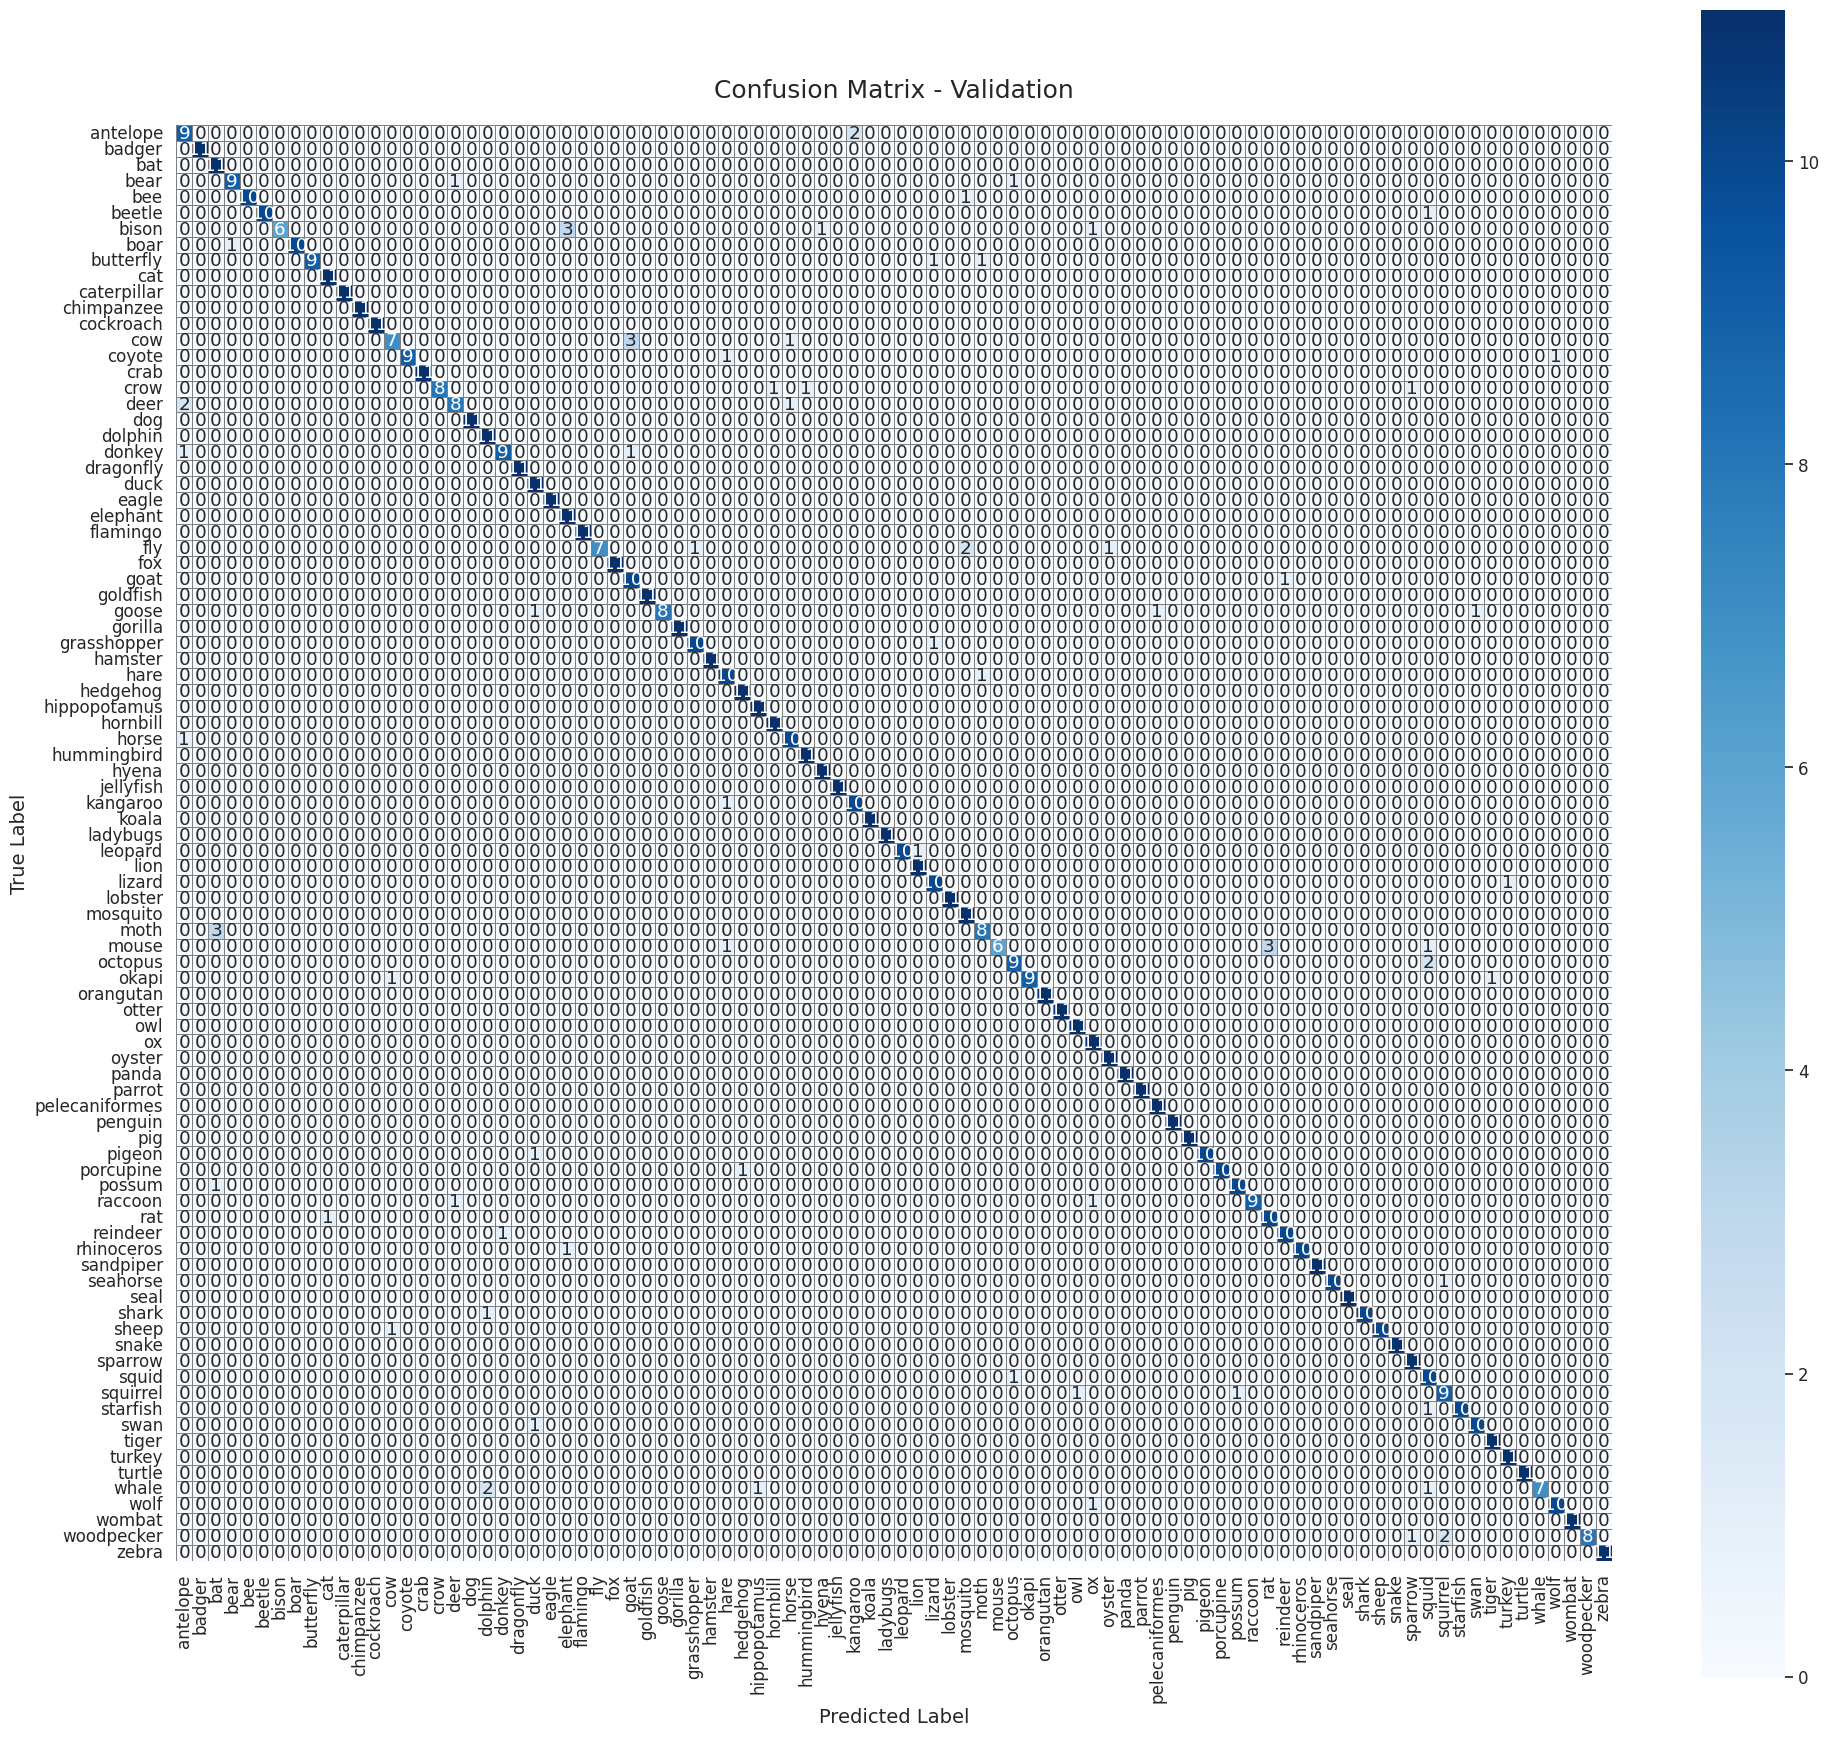

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix verileri
cm = confusion_matrix(y_true, y_pred)
labels = val_dataset.classes

# Plot ayarları
plt.figure(figsize=(20, 18))
sns.set(font_scale=1.1)
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels,
            cbar=True,
            square=True,
            linewidths=0.5,
            linecolor='gray')

plt.title("Confusion Matrix - Validation", fontsize=18, pad=20)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=90, ha='center')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

model.eval()
indices = random.sample(range(len(val_dataset)), 10)

for idx in indices:
    img_tensor, true_label = val_dataset[idx]
    input_tensor = img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)

    predicted_class = val_dataset.classes[pred.item()]
    true_class = val_dataset.classes[true_label]

    # Tensor'dan görüntüye dönüş
    img_show = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_show = img_show * 0.229 + 0.485  # normalize geri al
    img_show = img_show.clip(0, 1)

    plt.imshow(img_show)
    result = "✅" if pred.item() == true_label else "❌"
    plt.title(f"{result} Tahmin: {predicted_class}\nGerçek: {true_class}", fontsize=12)
    plt.axis('off')
    plt.show()



Output hidden; open in https://colab.research.google.com to view.